# 3. Creating Table 1 for the PulseOx Dataset

## defines and imports

In [1]:
# replace protean-chassis-368116 with your own project id
%env GOOGLE_CLOUD_PROJECT = protean-chassis-368116

env: GOOGLE_CLOUD_PROJECT=protean-chassis-368116


In [2]:
# install if necessary
!pip install tableone

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from google.cloud import bigquery

import missingno as msno
import matplotlib.pyplot as plt

import numpy as np
from tableone import TableOne

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table

Authenticated


In [4]:
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
%config InlineBackend.figure_format = 'retina'

In [6]:
%%bigquery data

SELECT *
FROM `protean-chassis-368116.pulseox_physionet.merged_first_pairs_5min`

Query is running:   0%|          |

Downloading:   0%|          |

## unique ids

In [7]:
len(data)

49093

In [8]:
eicu = data[data.source_db == "eicu"]
len(eicu.groupby(by="subject_id").first())

39401

In [9]:
len(data.groupby(by=["subject_id", "source_db"]).first())

44902

In [10]:

len(data.groupby(by=["hospital_admission_id", "source_db"]).first())

49093

In [11]:
len(data.groupby(by=["icustay_id", "source_db"]).first())

49093

In [12]:
data[data.source_db == "mimic_iv"].subject_id.nunique()

4773

## completeness overall

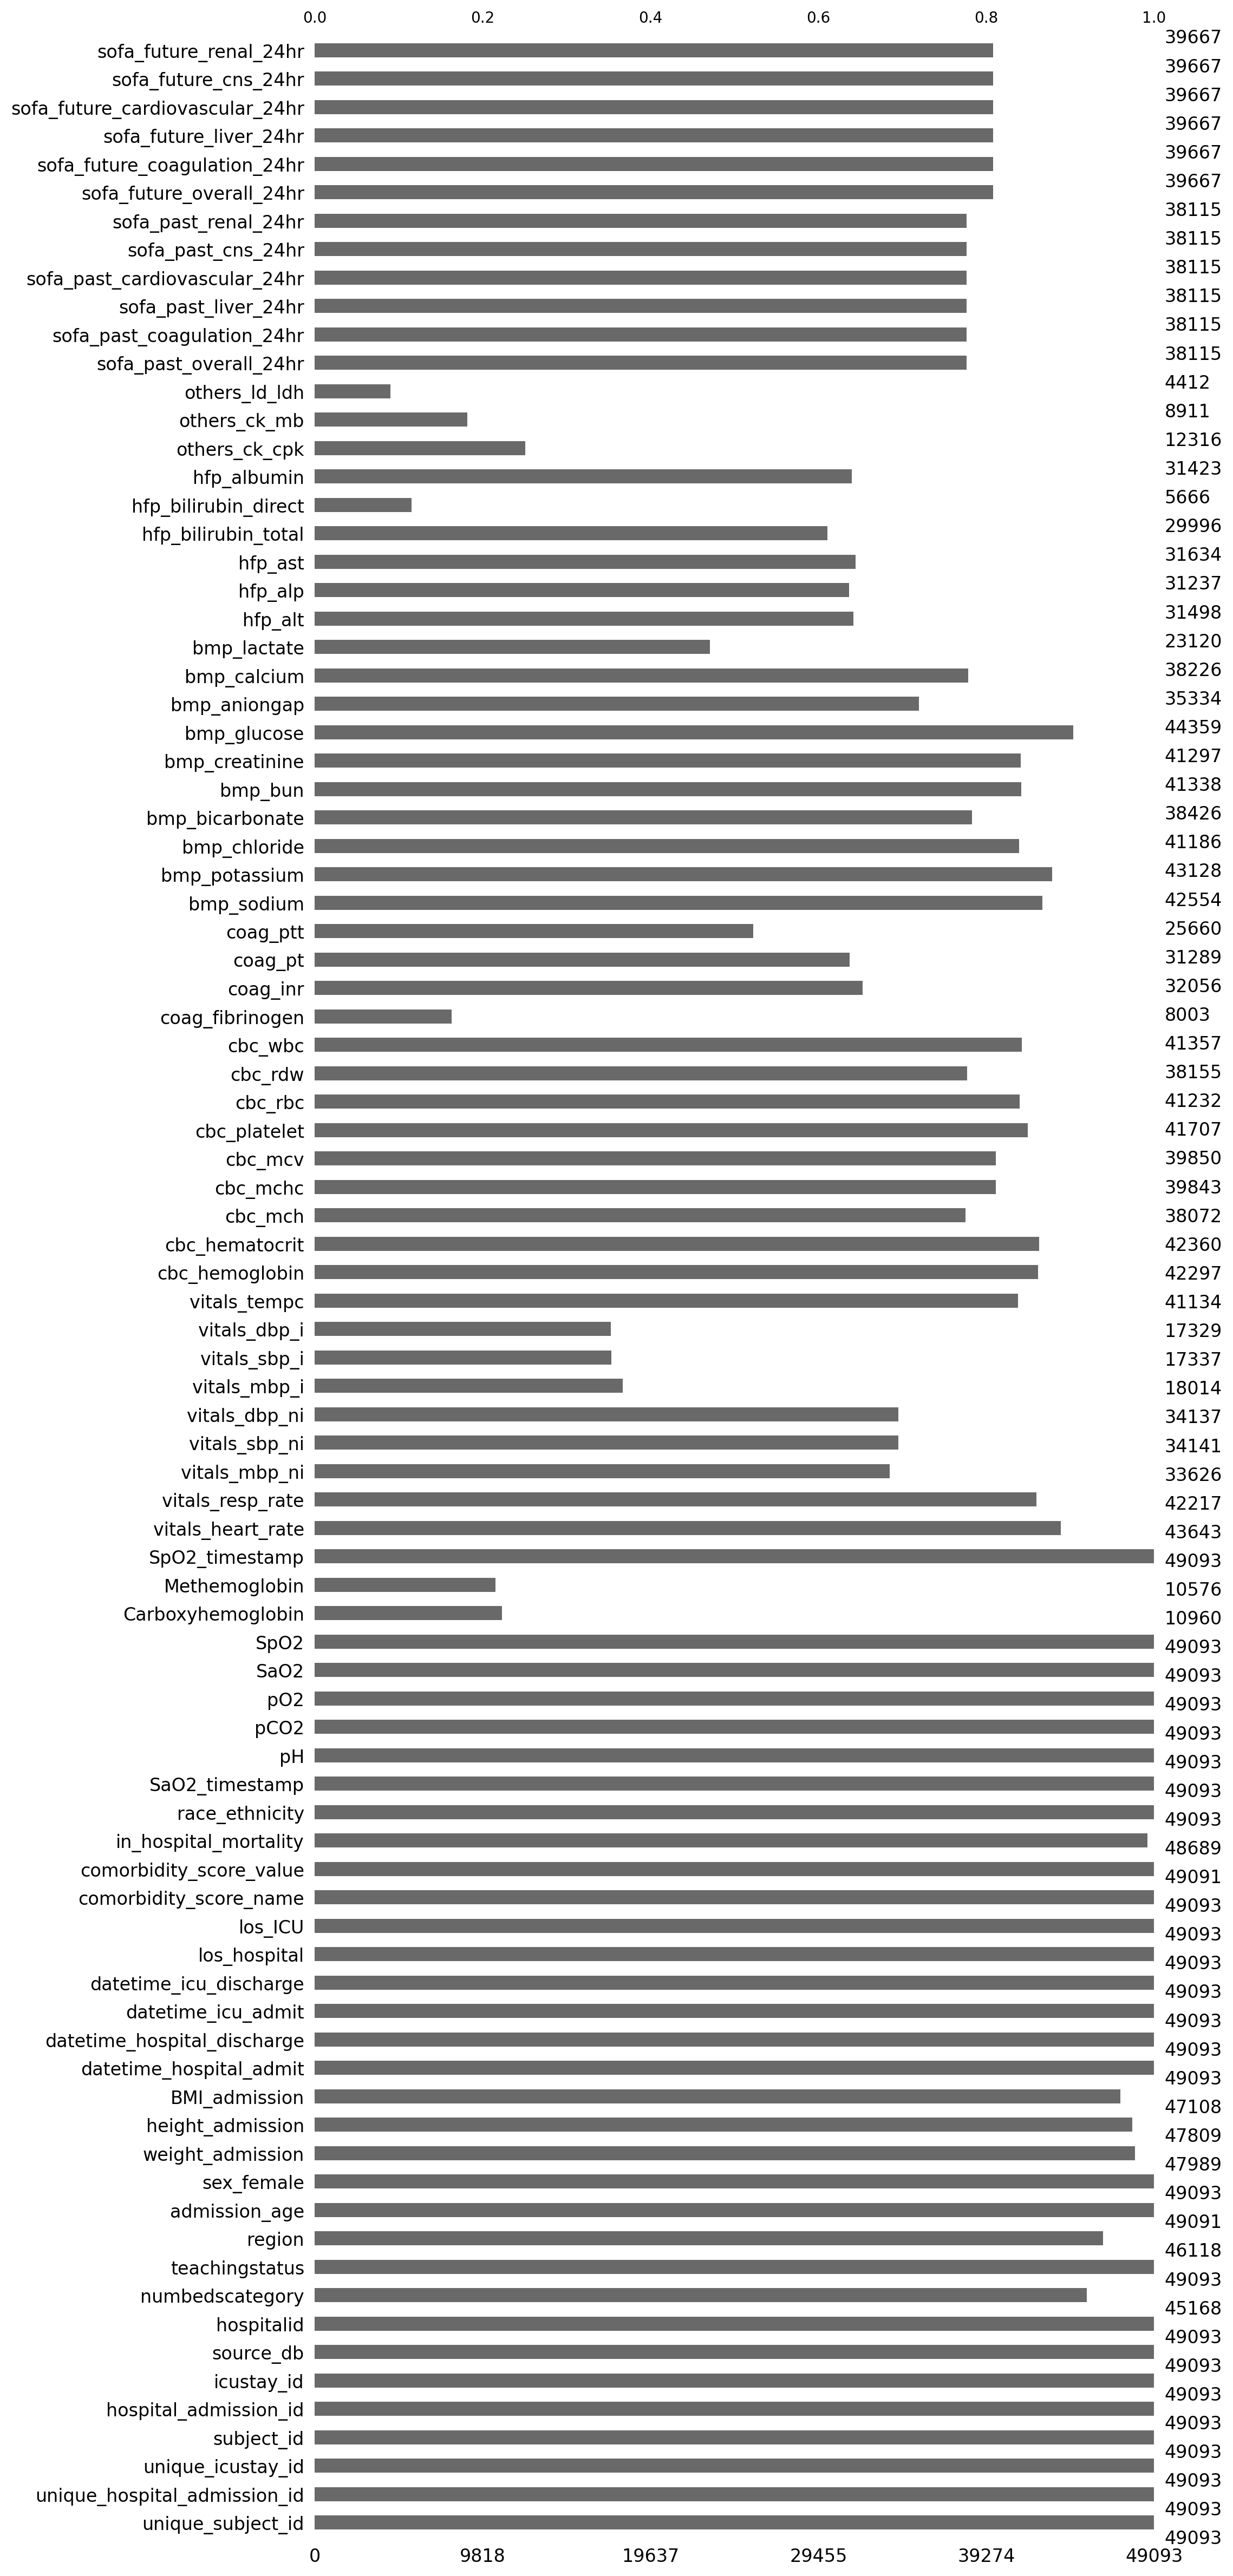

In [13]:
mdf = data[[column for column in data.columns if not column.startswith('delta_')]]

msno.bar(mdf, figsize=(10,30), fontsize=12)
plt.show()

## preprocess

In [14]:
# transform Charlson and Elixhauser score into a separate column for each
pivot_df = data.pivot_table(index=data.index,
                            columns='comorbidity_score_name',
                            values='comorbidity_score_value')

pivot_df.columns = [col if isinstance(col, str) else '' for col in pivot_df.columns]

# Assign the columns to the DataFrame
data['Elixhauser'] = pd.to_numeric(pivot_df['Elixhauser'], errors='coerce').astype('float64')
data["Charlson"] = pd.to_numeric(pivot_df['Charlson'], errors='coerce').astype('float64')

In [15]:
sofa_columns = data.filter(like="sofa_")
sofa_columns = sofa_columns.apply(pd.to_numeric, errors='coerce').astype('float64')
data[sofa_columns.columns] = sofa_columns

In [16]:
def hidden_hypoxemia(row):
    if row['SpO2'] >= 88 and row['SaO2'] < 88:
        return 1
    else:
        return 0

data['hidden_hypoxemia'] = data.apply(hidden_hypoxemia, axis=1)

In [17]:
data.replace('<NA>', np.nan, inplace=True)

In [18]:
with pd.option_context('display.max_columns',None):
  display(data.head(2))

,unique_subject_id,unique_hospital_admission_id,unique_icustay_id,subject_id,hospital_admission_id,icustay_id,source_db,hospitalid,numbedscategory,teachingstatus,region,admission_age,sex_female,weight_admission,height_admission,BMI_admission,datetime_hospital_admit,datetime_hospital_discharge,datetime_icu_admit,datetime_icu_discharge,los_hospital,los_ICU,comorbidity_score_name,comorbidity_score_value,in_hospital_mortality,race_ethnicity,SaO2_timestamp,pH,pCO2,pO2,SaO2,SpO2,Carboxyhemoglobin,Methemoglobin,SpO2_timestamp,delta_SpO2,delta_vitals_heart_rate,vitals_heart_rate,delta_vitals_resp_rate,vitals_resp_rate,delta_vitals_mbp_ni,vitals_mbp_ni,delta_vitals_sbp_ni,vitals_sbp_ni,delta_vitals_dbp_ni,vitals_dbp_ni,delta_vitals_mbp_i,vitals_mbp_i,delta_vitals_sbp_i,vitals_sbp_i,delta_vitals_dbp_i,vitals_dbp_i,delta_vitals_tempc,vitals_tempc,delta_cbc_hemoglobin,cbc_hemoglobin,delta_cbc_hematocrit,cbc_hematocrit,delta_cbc_mch,cbc_mch,delta_cbc_mchc,cbc_mchc,delta_cbc_mcv,cbc_mcv,delta_cbc_platelet,cbc_platelet,delta_cbc_rbc,cbc_rbc,delta_cbc_rdw,cbc_rdw,delta_cbc_wbc,cbc_wbc,delta_coag_fibrinogen,coag_fibrinogen,delta_coag_inr,coag_inr,delta_coag_pt,coag_pt,delta_coag_ptt,coag_ptt,delta_bmp_sodium,bmp_sodium,delta_bmp_potassium,bmp_potassium,delta_bmp_chloride,bmp_chloride,delta_bmp_bicarbonate,bmp_bicarbonate,delta_bmp_bun,bmp_bun,delta_bmp_creatinine,bmp_creatinine,delta_bmp_glucose,bmp_glucose,delta_bmp_aniongap,bmp_aniongap,delta_bmp_calcium,bmp_calcium,delta_bmp_lactate,bmp_lactate,delta_hfp_alt,hfp_alt,delta_hfp_alp,hfp_alp,delta_hfp_ast,hfp_ast,delta_hfp_bilirubin_total,hfp_bilirubin_total,delta_hfp_bilirubin_direct,hfp_bilirubin_direct,delta_hfp_albumin,hfp_albumin,delta_others_ck_cpk,others_ck_cpk,delta_others_ck_mb,others_ck_mb,delta_others_ld_ldh,others_ld_ldh,delta_sofa_past_overall_24hr,sofa_past_overall_24hr,delta_sofa_past_coagulation_24hr,sofa_past_coagulation_24hr,delta_sofa_past_liver_24hr,sofa_past_liver_24hr,delta_sofa_past_cardiovascular_24hr,sofa_past_cardiovascular_24hr,delta_sofa_past_cns_24hr,sofa_past_cns_24hr,delta_sofa_past_renal_24hr,sofa_past_renal_24hr,delta_sofa_future_overall_24hr,sofa_future_overall_24hr,delta_sofa_future_coagulation_24hr,sofa_future_coagulation_24hr,delta_sofa_future_liver_24hr,sofa_future_liver_24hr,delta_sofa_future_cardiovascular_24hr,sofa_future_cardiovascular_24hr,delta_sofa_future_cns_24hr,sofa_future_cns_24hr,delta_sofa_future_renal_24hr,sofa_future_renal_24hr,Elixhauser,Charlson,hidden_hypoxemia
0,4,4,4,002-10324,188445,217835,eicu,73,>= 500,True,Midwest,57.0,0,NaN,172.7,NaN,2013-12-29 23:23:00+00:00,2014-01-06 15:33:00+00:00,2014-01-01 00:00:00+00:00,2014-01-04 06:39:00+00:00,7.673611,3.291667,Charlson,1,0,White,2014-01-01 00:23:00+00:00,7.31,55.0,182.0,98.0,97.0,0.6,0.3,2014-01-01 00:20:00+00:00,-3.0,-9,94.0,-9,8.0,<NA>,NaN,-20,140.0,-20,55.0,-9,74.0,-9,114.0,-9,56.0,-20,36.4,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,-1822,1.1,-1822,11.2,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,-1822,19.0,-1822,60.0,-1822,12.0,-1822,1.1,<NA>,NaN,-1822,3.4,<NA>,NaN,<NA>,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1537.0,7.0,1537.0,1.0,1537.0,0.0,1537.0,1.0,1537.0,2.0,1537.0,0.0,NaN,1.0,0
1,10,10,10,002-10686,190309,220261,eicu,73,>= 500,True,Midwest,43.0,0,130.4,167.6,46.422611,2013-12-31 23:51:00+00:00,2014-01-08 22:07:00+00:00,2014-01-01 00:00:00+00:00,2014-01-07 02:41:00+00:00,7.927778,6.125000,Charlson,1,0,Black,2014-01-04 12:59:00+00:00,7.34,32.0,141.0,98.0,100.0,NaN,NaN,2014-01-04 12:55:00+00:00,-4.0,-16,86.0,-76,14.0,<NA>,NaN,<NA>,NaN,<NA>,NaN,-16,90.0,-16,126.0,-16,72.0,-76,37.7,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,-1564,1.8,-1564,19.5,-1564,42.0,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,-5284,19.0,-5284,72.0,-5284,13.0,-5284,0.9,<NA>,NaN,-5284,3.2,<NA>,NaN,<NA>

In [19]:
# Encode race_white as being white vs. non-white
data['race_ethnicity_white'] = data['race_ethnicity'] \
                              .apply(lambda x: "White" if x == "White" \
                                       else "Racial-Ethnic Group")

# Continuous Variables
data['los_hosp_dead'] = data[data.in_hospital_mortality == 1].los_hospital
data['los_hosp_surv'] = data[data.in_hospital_mortality == 0].los_hospital

data['los_ICU_dead'] = data[data.in_hospital_mortality == 1].los_ICU
data['los_ICU_surv'] = data[data.in_hospital_mortality == 0].los_ICU

data['n_pairs'] = data.groupby(['hospital_admission_id'])['pO2'].transform('size')

In [20]:
#data.query('n_readings >= 2').sort_values(by=['hospital_admission_id']).head(10)
data['n_pairs'].describe()

count    49093.000000
mean         1.000367
std          0.019145
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: n_pairs, dtype: float64

In [21]:
vitals =      [c for c in data.columns if c.startswith('vitals_')]
cbc =         [c for c in data.columns if c.startswith('cbc_')]
coag =        [c for c in data.columns if c.startswith('coag_')]
bmp =         [c for c in data.columns if c.startswith('bmp_')]
hfp =         [c for c in data.columns if c.startswith('hfp_')]
others =      [c for c in data.columns if c.startswith('others_')]
sofa_past =   [c for c in data.columns if c.startswith('sofa_past_')]
sofa_future = [c for c in data.columns if c.startswith('sofa_future_')]
deltas =      [c for c in data.columns if c.startswith('delta_')]

bgs = ["pH", "pCO2", "pO2", "SaO2", "SpO2", "delta_SpO2",
       "Carboxyhemoglobin", "Methemoglobin"]

pat_categ = ["source_db", "region", "sex_female",
             "race_ethnicity", "in_hospital_mortality"]

pat_cont = ["admission_age","weight_admission", "height_admission",
            "BMI_admission", "los_hosp_dead", "los_hosp_surv",
            "los_ICU_dead", "los_ICU_surv","Charlson", "Elixhauser", 'n_pairs']

## strat by source_db

### table one patients level

In [22]:
data_pat = data.groupby(by=["subject_id", "hospital_admission_id"]).first().reset_index()

In [23]:
groupby = ["source_db"]
categ = list(set(pat_categ) - set(groupby))
nonnorm = pat_cont
cols = categ + nonnorm

In [24]:
data_pat.head(2)

,subject_id,hospital_admission_id,unique_subject_id,unique_hospital_admission_id,unique_icustay_id,icustay_id,source_db,hospitalid,numbedscategory,teachingstatus,...,sofa_future_renal_24hr,Elixhauser,Charlson,hidden_hypoxemia,race_ethnicity_white,los_hosp_dead,los_hosp_surv,los_ICU_dead,los_ICU_surv,n_pairs
0,002-10050,183274,0,0,0,211144,eicu,71,100 - 249,False,...,0.0,NaN,3.0,0,White,NaN,6.780556,NaN,3.833333,1
1,002-1007,178462,1,1,1,204935,eicu,71,100 - 249,False,...,NaN,NaN,9.0,0,White,2.603472,NaN,0.5,NaN,1


In [25]:
table1_pat = TableOne(data_pat, columns=cols,
                      groupby=groupby, categorical=categ, nonnormal=nonnorm,
                      missing=True, overall=False)

In [26]:
with pd.option_context('display.max_columns', None, 'display.max_rows',None):
  display(table1_pat)

  # also download
  table1_pat.to_excel('table1_pat_by_HH.xlsx')
  files.download('table1_pat_by_HH.xlsx')

Grouped by source_db                                                               
                                                                                 Missing                 eicu            mimic_iii             mimic_iv
n                                                                                                       43438                  740                 4915
region, n (%)                    Midwest                                            2975         13979 (34.5)                                          
                                 Northeast                                                         3397 (8.4)          740 (100.0)         4915 (100.0)
                                 South                                                           14018 (34.6)                                          
                                 West                                                             9069 (22.4)                                          
in_hospital_mortality, n (%)     0                                                   404         35383 (82.2)           611 (82.6)          4153 (84.5)
                                 1                                                                7651 (17.8)           129 (17.4)           762 (15.5)
sex_female, n (%)                0                                                     0         24007 (55.3)           456 (61.6)          3197 (65.0)
                                 1                                                               19431 (44.7)           284 (38.4)          1718 (35.0)
race_ethnicity, n (%)            American Indian / Alaska Native                       0            371 (0.9)                                   9 (0.2)
                                 Asian                                                              723 (1.7)             16 (2.2)            119 (2.4)
                                 Black                                                            4405 (10.1)             42 (5.7)            338 (6.9)
                                 Hispanic OR Latino                                                1934 (4.5)             20 (2.7)            162 (3.3)
                                 Unknown                                                           2648 (6.1)             72 (9.7)           842 (17.1)
                                 White                                                           33357 (76.8)           590 (79.7)          3433 (69.8)
                                 More Than One Race                                                                                             3 (0.1)
                                 Native Hawaiian / Pacific Islander                                                                             9 (0.2)
admission_age, median [Q1,Q3]                                                          2     66.0 [55.0,76.0]     68.0 [58.0,77.0]     68.0 [59.0,77.0]
weight_admission, median [Q1,Q3]                                                    1104     81.3 [67.0,99.4]     82.5 [70.0,97.9]     82.0 [70.0,97.2]
height_admission, median [Q1,Q3]                                                    1284  170.0 [162.5,177.8]  170.2 [162.6,177.8]  170.0 [163.0,178.0]
BMI_admission, median [Q1,Q3]                                                       1985     28.0 [23.7,33.7]     28.3 [24.7,33.5]     28.3 [24.7,32.7]
los_hosp_dead, median [Q1,Q3]                                                      40551       5.5 [2.3,11.6]      11.0 [5.0,23.0]      12.0 [6.0,21.0]
los_hosp_surv, median [Q1,Q3]                                                       8946       8.3 [5.1,14.0]      10.0 [7.0,18.0]      10.0 [6.0,18.0]
los_ICU_dead, median [Q1,Q3]                                                       40551        3.2 [1.4,6.8]       9.0 [3.0,17.0]       8.9 [4.1,15.0]
los_ICU_surv, median [Q1,Q3]                                                        8946        2.9 [1.7,5.7]       

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### table one pairs level

In [27]:
groupby = ["source_db"]
categ = ["hidden_hypoxemia"]
nonnorm = bgs + vitals + cbc + coag + bmp + hfp + others + sofa_past + sofa_future
cols = categ + nonnorm

In [28]:
table1_pair = TableOne(data, columns=cols,
                       groupby=groupby, categorical=categ, nonnormal=nonnorm,
                       missing=True, overall=False)

In [29]:
with pd.option_context('display.max_columns', None, 'display.max_rows',None):
  display(table1_pair)

  # also download
  table1_pair.to_excel('table1_pair_by_db.xlsx')
  files.download('table1_pair_by_db.xlsx')

Grouped by source_db                                                               
                                                               Missing                 eicu            mimic_iii             mimic_iv
n                                                                                     43438                  740                 4915
hidden_hypoxemia, n (%)                         0                    0         41752 (96.1)           722 (97.6)          4888 (99.5)
                                                1                                1686 (3.9)             18 (2.4)             27 (0.5)
pH, median [Q1,Q3]                                                   0        7.4 [7.3,7.4]        7.4 [7.3,7.4]        7.4 [7.3,7.4]
pCO2, median [Q1,Q3]                                                 0     40.0 [34.0,48.0]     40.0 [35.0,46.0]     39.0 [35.0,44.0]
pO2, median [Q1,Q3]                                                  0    98.0 [75.0,145.3]   110.0 [83.0,152.2]   112.0 [88.0,149.0]
SaO2, median [Q1,Q3]                                                 0     97.0 [94.1,99.0]     97.0 [95.0,98.0]     97.0 [95.0,98.0]
SpO2, median [Q1,Q3]                                                 0    98.0 [96.0,100.0]    98.0 [95.0,100.0]    99.0 [96.0,100.0]
delta_SpO2, median [Q1,Q3]                                           0     -2.0 [-3.0,-1.0]     -3.0 [-4.0,-1.0]     -2.0 [-4.0,-1.0]
Carboxyhemoglobin, median [Q1,Q3]                                38133        0.8 [0.3,1.3]        1.0 [0.9,1.2]        1.0 [1.0,1.9]
Methemoglobin, median [Q1,Q3]                                    38517        0.4 [0.3,0.6]        0.3 [0.2,0.7]        0.3 [0.0,1.0]
vitals_heart_rate, median [Q1,Q3]                                 5450    88.0 [75.0,103.0]     87.0 [77.0,98.0]     83.0 [74.0,94.0]
vitals_resp_rate, median [Q1,Q3]                                  6876     19.0 [15.0,24.0]     18.0 [15.0,23.0]     18.0 [15.0,22.0]
vitals_mbp_ni, median [Q1,Q3]                                    15467     78.0 [67.0,90.0]     72.5 [64.0,81.2]     72.0 [63.0,82.0]
vitals_sbp_ni, median [Q1,Q3]                                    14952  115.0 [100.0,133.0]   112.0 [97.0,129.0]   109.0 [97.0,123.0]
vitals_dbp_ni, median [Q1,Q3]                                    14956     63.0 [54.0,75.0]     59.0 [50.0,68.0]     60.0 [51.0,69.0]
vitals_mbp_i, median [Q1,Q3]                                     31079     76.0 [67.0,88.0]     75.0 [67.0,85.0]     74.0 [67.0,82.0]
vitals_sbp_i, median [Q1,Q3]                                     31756  115.0 [101.0,133.0]  112.0 [101.0,127.0]  111.0 [101.0,124.0]
vitals_dbp_i, median [Q1,Q3]                                     31764     57.0 [50.0,67.0]     57.0 [51.0,65.0]     57.0 [50.0,64.0]
vitals_tempc, median [Q1,Q3]                                      7959     36.7 [36.4,37.2]     36.9 [36.2,37.4]     36.8 [36.4,37.2]
cbc_hemoglobin, median [Q1,Q3]                                    6796      11.1 [9.5,12.9]      10.0 [8.9,11.3]      10.2 [9.1,11.5]
cbc_hematocrit, median [Q1,Q3]                                    6733     33.8 [28.9,39.0]     30.0 [27.0,34.0]     30.2 [27.2,33.9]
cbc_mch, median [Q1,Q3]                                          11021     30.0 [28.4,31.3]     30.4 [29.1,31.6]     30.3 [29.0,31.5]
cbc_mchc, median [Q1,Q3]                                          9250     32.9 [31.8,33.9]     34.0 [32.8,35.0]     33.4 [32.4,34.4]
cbc_mcv, median [Q1,Q3]                                           9243     91.0 [87.0,95.0]     89.0 [86.0,93.0]     90.0 [87.0,94.0]
cbc_platelet, median [Q1,Q3]                                      7386  192.0 [137.0,260.0]  181.0 [132.0,239.8]  156.0 [116.0,210.0]
cbc_rbc, median [Q1,Q3]                                           7861        3.8 [3.2,4.3]        3.3 [3.0,3.7]        3.4 [3.0,3.8]
cbc_rdw, median [Q1,Q3]                                          10938     14.8 [13.7,16.5]     15.0 [14.0,16.3]     14.6 [13.5,16.0]
cbc_wbc, median [Q1,Q3]       

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## strat by race_ethnicity

### table one patients level

In [30]:
groupby = ["race_ethnicity_white"]
categ = list(set(pat_categ) - set(groupby))
nonnorm = pat_cont
cols = categ + nonnorm

data_pat = data.groupby(by=["subject_id", "hospital_admission_id"]).first().reset_index()

table1_pat = TableOne(data_pat, columns=cols,
                      groupby=groupby, categorical=categ, nonnormal=nonnorm,
                      missing=True, overall=False)

with pd.option_context('display.max_columns', None, 'display.max_rows',None):
  display(table1_pat)

  # also download
  table1_pat.to_excel('table1_pat_by_race.xlsx')
  files.download('table1_pat_by_race.xlsx')

Grouped by race_ethnicity_white                                          
                                                                                            Missing  Racial-Ethnic Group                White
n                                                                                                                  11713                37380
region, n (%)                    Midwest                                                       2975          2333 (21.7)         11646 (32.9)
                                 Northeast                                                                   1979 (18.4)          7073 (20.0)
                                 South                                                                       4586 (42.6)          9432 (26.7)
                                 West                                                                        1870 (17.4)          7199 (20.4)
in_hospital_mortality, n (%)     0                                                              404          9548 (82.3)         30599 (82.5)
                                 1                                                                           2058 (17.7)          6484 (17.5)
source_db, n (%)                 eicu                                                             0         10081 (86.1)         33357 (89.2)
                                 mimic_iii                                                                     150 (1.3)            590 (1.6)
                                 mimic_iv                                                                    1482 (12.7)           3433 (9.2)
sex_female, n (%)                0                                                                0          6497 (55.5)         21163 (56.6)
                                 1                                                                           5216 (44.5)         16217 (43.4)
race_ethnicity, n (%)            American Indian / Alaska Native                                  0            380 (3.2)                     
                                 Asian                                                                         858 (7.3)                     
                                 Black                                                                       4785 (40.9)                     
                                 Hispanic OR Latino                                                          2116 (18.1)                     
                                 More Than One Race                                                              3 (0.0)                     
                                 Native Hawaiian / Pacific Islander                                              9 (0.1)                     
                                 Unknown                                                                     3562 (30.4)                     
                                 White                                                                                          37380 (100.0)
admission_age, median [Q1,Q3]                                                                     2     63.0 [51.0,74.0]     67.0 [57.0,77.0]
weight_admission, median [Q1,Q3]                                                               1104     79.0 [65.6,96.5]     82.0 [68.0,99.8]
height_admission, median [Q1,Q3]                                                               1284  167.6 [160.0,175.3]  170.2 [162.6,177.8]
BMI_admission, median [Q1,Q3]                                                                  1985     27.7 [23.6,33.3]     28.2 [23.9,33.6]
los_hosp_dead, median [Q1,Q3]                                                                 40551       6.9 [3.0,14.9]       5.7 [2.4,12.0]
los_hosp_surv, median [Q1,Q3]                                                                  8946       9.1 [5.4,15.8]       8.3 [5.2,14.1]
los_ICU_dead, median [Q1,Q3]                                                                

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### table one pairs level

In [31]:
groupby = ["race_ethnicity_white"]
categ = ["hidden_hypoxemia"]
nonnorm = bgs + vitals + cbc + coag + bmp + hfp + others + sofa_past + sofa_future
cols = categ + nonnorm

table1_pair = TableOne(data, columns=cols,
                       groupby=groupby, categorical=categ, nonnormal=nonnorm,
                       missing=True, overall=False)

with pd.option_context('display.max_columns', None, 'display.max_rows',None):
  display(table1_pair)

  # also download
  table1_pair.to_excel('table1_pair_by_race.xlsx')
  files.download('table1_pair_by_race.xlsx')

Grouped by race_ethnicity_white                                          
                                                                          Missing  Racial-Ethnic Group                White
n                                                                                                11713                37380
hidden_hypoxemia, n (%)                         0                               0         11296 (96.4)         36066 (96.5)
                                                1                                            417 (3.6)           1314 (3.5)
pH, median [Q1,Q3]                                                              0        7.4 [7.3,7.4]        7.4 [7.3,7.4]
pCO2, median [Q1,Q3]                                                            0     39.0 [33.2,46.0]     40.3 [34.5,48.0]
pO2, median [Q1,Q3]                                                             0   104.0 [78.0,153.0]    98.1 [76.0,144.0]
SaO2, median [Q1,Q3]                                                            0     97.0 [95.0,99.0]     97.0 [94.3,99.0]
SpO2, median [Q1,Q3]                                                            0    99.0 [96.0,100.0]    98.0 [95.0,100.0]
delta_SpO2, median [Q1,Q3]                                                      0     -2.0 [-3.0,-1.0]     -2.0 [-3.0,-1.0]
Carboxyhemoglobin, median [Q1,Q3]                                           38133        0.8 [0.3,1.2]        0.9 [0.4,1.4]
Methemoglobin, median [Q1,Q3]                                               38517        0.3 [0.2,0.6]        0.4 [0.3,0.7]
vitals_heart_rate, median [Q1,Q3]                                            5450    88.0 [76.0,103.0]    87.0 [75.0,102.0]
vitals_resp_rate, median [Q1,Q3]                                             6876     19.0 [15.0,24.0]     19.0 [15.0,23.5]
vitals_mbp_ni, median [Q1,Q3]                                               15467     79.0 [68.0,92.0]     77.0 [67.0,89.0]
vitals_sbp_ni, median [Q1,Q3]                                               14952  117.0 [101.0,136.0]  114.0 [100.0,132.0]
vitals_dbp_ni, median [Q1,Q3]                                               14956     65.0 [55.0,76.0]     63.0 [54.0,74.0]
vitals_mbp_i, median [Q1,Q3]                                                31079     76.0 [68.0,88.0]     75.0 [67.0,85.0]
vitals_sbp_i, median [Q1,Q3]                                                31756  115.0 [101.0,132.0]  114.0 [101.0,129.0]
vitals_dbp_i, median [Q1,Q3]                                                31764     58.0 [51.0,68.0]     57.0 [50.0,65.0]
vitals_tempc, median [Q1,Q3]                                                 7959     36.8 [36.4,37.2]     36.7 [36.4,37.2]
cbc_hemoglobin, median [Q1,Q3]                                               6796      10.8 [9.2,12.6]      11.0 [9.5,12.8]
cbc_hematocrit, median [Q1,Q3]                                               6733     32.7 [28.0,38.1]     33.3 [28.7,38.6]
cbc_mch, median [Q1,Q3]                                                     11021     29.6 [28.0,31.0]     30.1 [28.7,31.5]
cbc_mchc, median [Q1,Q3]                                                     9250     33.0 [31.9,33.9]     33.0 [31.9,34.0]
cbc_mcv, median [Q1,Q3]                                                      9243     89.3 [85.0,94.0]     91.0 [87.1,95.1]
cbc_platelet, median [Q1,Q3]                                                 7386  187.0 [132.0,255.0]  187.0 [135.0,254.0]
cbc_rbc, median [Q1,Q3]                                                      7861        3.7 [3.2,4.3]        3.7 [3.2,4.3]
cbc_rdw, median [Q1,Q3]                                                     10938     15.0 [13.8,16.7]     14.7 [13.7,16.3]
cbc_wbc, median [Q1,Q3]                                                      7736      11.6 [8.3,16.1]      12.2 [8.7,17.0]
coag_fibrinogen, median [Q1,Q3]                                             41090  232.0 [177.0,326.8]  236.0 [179.0,320.0]
coag_inr, median [Q1,Q3]                                                    17037 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## strat by hidden hypoxemia

### table one patients level

In [32]:
groupby = ["hidden_hypoxemia"]
categ = list(set(pat_categ) - set(groupby))
nonnorm = pat_cont
cols = categ + nonnorm

data_pat = data.groupby(by=["subject_id", "hospital_admission_id"]).first().reset_index()

table1_pat = TableOne(data_pat, columns=cols,
                      groupby=groupby, categorical=categ, nonnormal=nonnorm,
                      missing=True, overall=False)

with pd.option_context('display.max_columns', None, 'display.max_rows',None):
  display(table1_pat)

  # also download
  table1_pat.to_excel('table1_pat_by_HH2.xlsx')
  files.download('table1_pat_by_HH2.xlsx')

Grouped by hidden_hypoxemia                                          
                                                                                        Missing                    0                    1
n                                                                                                              47362                 1731
region, n (%)                    Midwest                                                   2975         13334 (30.0)           645 (39.0)
                                 Northeast                                                               8802 (19.8)           250 (15.1)
                                 South                                                                  13564 (30.5)           454 (27.4)
                                 West                                                                    8764 (19.7)           305 (18.4)
in_hospital_mortality, n (%)     0                                                          404         38875 (82.8)          1272 (73.9)
                                 1                                                                       8092 (17.2)           450 (26.1)
source_db, n (%)                 eicu                                                         0         41752 (88.2)          1686 (97.4)
                                 mimic_iii                                                                 722 (1.5)             18 (1.0)
                                 mimic_iv                                                                4888 (10.3)             27 (1.6)
sex_female, n (%)                0                                                            0         26728 (56.4)           932 (53.8)
                                 1                                                                      20634 (43.6)           799 (46.2)
race_ethnicity, n (%)            American Indian / Alaska Native                              0            371 (0.8)              9 (0.5)
                                 Asian                                                                     836 (1.8)             22 (1.3)
                                 Black                                                                    4569 (9.6)           216 (12.5)
                                 Hispanic OR Latino                                                       2046 (4.3)             70 (4.0)
                                 More Than One Race                                                          3 (0.0)                     
                                 Native Hawaiian / Pacific Islander                                          9 (0.0)                     
                                 Unknown                                                                  3462 (7.3)            100 (5.8)
                                 White                                                                  36066 (76.1)          1314 (75.9)
admission_age, median [Q1,Q3]                                                                 2     66.0 [55.0,76.0]     65.0 [54.0,75.0]
weight_admission, median [Q1,Q3]                                                           1104     81.5 [67.4,99.0]    81.2 [66.5,102.4]
height_admission, median [Q1,Q3]                                                           1284  170.0 [162.6,177.8]  168.9 [160.0,177.8]
BMI_admission, median [Q1,Q3]                                                              1985     28.1 [23.8,33.5]     28.2 [23.8,35.6]
los_hosp_dead, median [Q1,Q3]                                                             40551       6.0 [2.6,12.7]       4.6 [1.8,10.8]
los_hosp_surv, median [Q1,Q3]                                                              8946       8.5 [5.2,14.4]       9.1 [5.4,16.0]
los_ICU_dead, median [Q1,Q3]                                                              40551        3.6 [1.6,7.7]        2.6 [1.0,5.9]
los_ICU_surv, median [Q1,Q3]                                      

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### table one pairs level

In [33]:
groupby = ["hidden_hypoxemia"]
categ = []
nonnorm = bgs + vitals + cbc + coag + bmp + hfp + others + sofa_past + sofa_future
cols = categ + nonnorm

table1_pair = TableOne(data, columns=cols,
                       groupby=groupby, categorical=categ, nonnormal=nonnorm,
                       missing=True, overall=False)

with pd.option_context('display.max_columns', None, 'display.max_rows',None):
  display(table1_pair)

  # also download
  table1_pair.to_excel('table1_pair_by_HH.xlsx')
  files.download('table1_pair_by_HH.xlsx')

Grouped by hidden_hypoxemia                                          
                                                                     Missing                    0                    1
n                                                                                           47362                 1731
pH, median [Q1,Q3]                                                         0        7.4 [7.3,7.4]        7.3 [7.2,7.4]
pCO2, median [Q1,Q3]                                                       0     40.0 [34.0,47.0]     46.0 [37.0,58.4]
pO2, median [Q1,Q3]                                                        0   102.0 [78.0,148.8]     53.8 [48.0,59.0]
SaO2, median [Q1,Q3]                                                       0     97.0 [95.0,99.0]     84.8 [81.0,86.1]
SpO2, median [Q1,Q3]                                                       0    99.0 [96.0,100.0]     93.0 [91.0,97.0]
delta_SpO2, median [Q1,Q3]                                                 0     -2.0 [-3.0,-1.0]     -2.0 [-3.0,-1.0]
Carboxyhemoglobin, median [Q1,Q3]                                      38133        0.8 [0.3,1.3]        1.1 [0.5,1.7]
Methemoglobin, median [Q1,Q3]                                          38517        0.4 [0.2,0.6]        0.4 [0.3,0.7]
vitals_heart_rate, median [Q1,Q3]                                       5450    87.0 [75.0,102.0]    92.0 [79.0,108.0]
vitals_resp_rate, median [Q1,Q3]                                        6876     19.0 [15.0,23.0]     21.0 [17.0,26.0]
vitals_mbp_ni, median [Q1,Q3]                                          15467     77.0 [67.0,90.0]     76.0 [65.0,89.0]
vitals_sbp_ni, median [Q1,Q3]                                          14952  115.0 [100.0,133.0]   113.0 [98.0,131.0]
vitals_dbp_ni, median [Q1,Q3]                                          14956     63.0 [54.0,74.0]     61.0 [52.0,73.0]
vitals_mbp_i, median [Q1,Q3]                                           31079     76.0 [67.0,86.0]     75.0 [64.0,85.5]
vitals_sbp_i, median [Q1,Q3]                                           31756  114.0 [101.0,130.0]   110.5 [95.0,131.0]
vitals_dbp_i, median [Q1,Q3]                                           31764     57.0 [50.0,66.0]     56.0 [47.0,67.0]
vitals_tempc, median [Q1,Q3]                                            7959     36.7 [36.4,37.2]     36.7 [36.3,37.2]
cbc_hemoglobin, median [Q1,Q3]                                          6796      11.0 [9.4,12.7]      10.8 [9.2,12.9]
cbc_hematocrit, median [Q1,Q3]                                          6733     33.1 [28.5,38.4]     33.2 [28.1,39.0]
cbc_mch, median [Q1,Q3]                                                11021     30.0 [28.5,31.4]     30.0 [28.2,31.4]
cbc_mchc, median [Q1,Q3]                                                9250     33.0 [31.9,34.0]     32.4 [31.2,33.6]
cbc_mcv, median [Q1,Q3]                                                 9243     90.8 [87.0,95.0]     91.9 [87.3,96.8]
cbc_platelet, median [Q1,Q3]                                            7386  187.0 [134.0,255.0]  187.5 [130.8,256.0]
cbc_rbc, median [Q1,Q3]                                                 7861        3.7 [3.2,4.3]        3.7 [3.1,4.3]
cbc_rdw, median [Q1,Q3]                                                10938     14.8 [13.7,16.4]     15.5 [14.2,17.1]
cbc_wbc, median [Q1,Q3]                                                 7736      12.1 [8.6,16.8]      11.9 [7.9,17.2]
coag_fibrinogen, median [Q1,Q3]                                        41090  234.0 [179.0,320.0]  284.5 [169.5,407.5]
coag_inr, median [Q1,Q3]                                               17037        1.2 [1.1,1.5]        1.2 [1.1,1.6]
coag_pt, median [Q1,Q3]                                                17804     14.7 [13.0,17.2]     15.0 [13.0,18.3]
coag_ptt, median [Q1,Q3]                                               23433     32.0 [28.0,38.3]     33.5 [28.6,42.0]
bmp_sodium, median [Q1,Q3]                                              6539  139.0 [136.0,142.0]  138.0 [135.0,142.0]
bmp

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>